In [1]:
#importing libraries
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install imageio


Note: you may need to restart the kernel to use updated packages.


In [3]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
%matplotlib inline

import imageio.v2 as imageio

import os, shutil
from os import listdir, path

Matplotlib created a temporary cache directory at /tmp/matplotlib-ytajq1bc because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [6]:
import tensorflow as tf
import os
import cv2

2024-05-14 18:28:32.485689: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 18:28:33.735752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# Avoid OOM errors by setting memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
pip install google-api-python-client


Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install PyDrive


Note: you may need to restart the kernel to use updated packages.


In [10]:
augmented_data_path = '/teamspace/studios/this_studio/Augmented Data'


In [11]:
import os

# Define the path to the folder
augmented_data_path = '/teamspace/studios/this_studio/Augmented Data'

# Initialize a count for the number of images
image_count = 0

# Loop through all files in the folder
for filename in os.listdir(augmented_data_path):
    # Check if the file is an image file (assuming jpg, png, etc.)
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        # Increment the image count
        image_count += 1

# Print the total count of images
print("Total number of images:", image_count)


Total number of images: 7287


In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

augmented_data_path = '/teamspace/studios/this_studio/Augmented Data'

# Collect all the image file paths and their labels
image_files = []
labels = []

# os.listdir is used here to list all files in the directory
for file in os.listdir(augmented_data_path):
    if file.endswith('.jpeg'):  # Check for jpeg images
        image_files.append(os.path.join(augmented_data_path, file))
        labels.append(0 if 'Benign' in file else 1)  # Check for 'Benign' or 'Malignant' in the filename

# Check if the lists are populated
if not image_files:
    raise ValueError("No images found. Check the directory path and file naming convention.")

# Split the data into training+validation sets and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    image_files, labels, test_size=0.1, random_state=42, stratify=labels)  # 10% data as test set

# Split the temporary set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.22, random_state=42, stratify=y_temp)  # 22% of remaining data as validation set

# Convert the lists into Pandas DataFrames for easier manipulation
train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
val_df = pd.DataFrame({'filename': X_val, 'class': y_val})
test_df = pd.DataFrame({'filename': X_test, 'class': y_test})



In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for the training set with the appropriate rescaling
train_datagen = ImageDataGenerator(rescale=1./255)

# Make sure that the train_df 'class' column is converted to string type
train_df['class'] = train_df['class'].astype(str)

# Now create the data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),  # Make sure to use the same target size as your model expects
    class_mode='binary',  # Use 'binary' for binary classification problems
    batch_size=32  # Or another batch size that fits your setup
)

# Convert 'class' column to strings if it's not already
test_df['class'] = test_df['class'].astype(str)

test_datagen = ImageDataGenerator(rescale=1./255)

# Now, create the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),  # make sure to match the input size of your network
    class_mode='binary',  # for binary classification, Keras expects the labels to be strings
    batch_size=32,
    shuffle=False  # Do not shuffle test data
)

# Define a similar ImageDataGenerator for the validation data
val_datagen = ImageDataGenerator(rescale=1./255)
val_df['class'] = val_df['class'].astype(str)  # Also ensure the validation 'class' is a string

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32
)





Found 5115 validated image filenames belonging to 2 classes.
Found 729 validated image filenames belonging to 2 classes.
Found 1443 validated image filenames belonging to 2 classes.


In [14]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import joblib  # for saving the model

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

def extract_features(file_list, batch_size=32):
    """This function uses VGG16 to extract features from the images."""
    features = []
    for i in range(0, len(file_list), batch_size):
        batch = file_list[i:i+batch_size]
        imgs = [img_to_array(load_img(img, target_size=(150, 150))) for img in batch]
        imgs = np.array(imgs)
        imgs = preprocess_input(imgs)
        batch_features = base_model.predict(imgs, batch_size=batch_size, verbose=1)
        features.append(batch_features)
    return np.vstack(features)

# Extract features for training and testing sets
train_features = extract_features(train_df['filename'])
test_features = extract_features(test_df['filename'])

# Reshape the extracted features to be suitable for SVM training
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

# Train the SVM classifier
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features, train_df['class'].astype(int))  # Ensure labels are integer

# Predict on the test set
predictions = svm_model.predict(test_features)
print("Test Accuracy:", accuracy_score(test_df['class'].astype(int), predictions))

# Optionally, save the model
joblib.dump(svm_model, 'lung_cancer_svm_model.pkl')

# Detailed classification report
print(classification_report(test_df['class'].astype(int), predictions))


2024-05-14 18:28:41.367337: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2024-05-14 18:28:41.545691: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2024-05-14 18:28:41.922642: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 46080000 exceeds 10% of free system memory.
2024-05-14 18:28:41.964758: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2024-05-14 18:28:42.110709: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [15]:
from keras.applications.resnet50 import ResNet50, preprocess_input

# Load the pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

def extract_features_resnet(file_list, batch_size=32):
    """Extract features using ResNet50 from the images."""
    features = []
    for i in range(0, len(file_list), batch_size):
        batch = file_list[i:i+batch_size]
        imgs = [img_to_array(load_img(img, target_size=(150, 150))) for img in batch]
        imgs = np.array(imgs)
        imgs = preprocess_input(imgs)
        batch_features = resnet_model.predict(imgs, batch_size=batch_size, verbose=1)
        features.append(batch_features)
    return np.vstack(features)

# Extract features for training and testing sets using ResNet50
train_features_resnet = extract_features_resnet(train_df['filename'])
test_features_resnet = extract_features_resnet(test_df['filename'])

# Reshape the extracted features to be suitable for SVM training
train_features_resnet = train_features_resnet.reshape(train_features_resnet.shape[0], -1)
test_features_resnet = test_features_resnet.reshape(test_features_resnet.shape[0], -1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize the SVM model
svm_resnet = SVC(kernel='linear', probability=True)

# Fit the SVM model on the training data
svm_resnet.fit(train_features_resnet, train_df['class'].astype(int))

# Predict on the test data
predictions_resnet = svm_resnet.predict(test_features_resnet)

# Evaluate the model
accuracy_resnet = accuracy_score(test_df['class'].astype(int), predictions_resnet)
print("Accuracy of SVM with ResNet50 features:", accuracy_resnet)
print(classification_report(test_df['class'].astype(int), predictions_resnet))

Accuracy of SVM with ResNet50 features: 0.8888888888888888
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       253
           1       0.92      0.91      0.91       476

    accuracy                           0.89       729
   macro avg       0.88      0.88      0.88       729
weighted avg       0.89      0.89      0.89       729



In [17]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from sklearn.svm import SVC

# Load the pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

def extract_features_vgg(file_list, batch_size=32):
    """Extract features using VGG16 from the images."""
    features = []
    for i in range(0, len(file_list), batch_size):
        batch = file_list[i:i+batch_size]
        imgs = [img_to_array(load_img(img, target_size=(150, 150))) for img in batch]
        imgs = np.array(imgs)
        imgs = preprocess_input(imgs)
        batch_features = vgg_model.predict(imgs, batch_size=batch_size, verbose=1)
        features.append(batch_features)
    return np.vstack(features)

# Extract features for training and testing sets using VGG16
train_features_vgg = extract_features_vgg(train_df['filename'])
test_features_vgg = extract_features_vgg(test_df['filename'])

# Reshape the extracted features
train_features_vgg = train_features_vgg.reshape(train_features_vgg.shape[0], -1)
test_features_vgg = test_features_vgg.reshape(test_features_vgg.shape[0], -1)

# Train the SVM on VGG16 features
svm_vgg = SVC(kernel='linear', probability=True)
svm_vgg.fit(train_features_vgg, train_df['class'].astype(int))

# Now, you can use svm_vgg for ensemble methods


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

SVC(kernel='linear', probability=True)

In [18]:
# Assume prob_vgg and prob_resnet are probability predictions from svm_vgg and svm_resnet
prob_vgg = svm_vgg.predict_proba(test_features_vgg)
prob_resnet = svm_resnet.predict_proba(test_features_resnet)

# Average the probabilities
average_prob = (prob_vgg + prob_resnet) / 2

# Convert probabilities to final predictions
final_predictions = np.argmax(average_prob, axis=1)

# Evaluate the averaged model
print("Accuracy of Averaged Predictions:", accuracy_score(test_df['class'].astype(int), final_predictions))
print(classification_report(test_df['class'].astype(int), final_predictions))


Accuracy of Averaged Predictions: 0.9163237311385459
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       253
           1       0.93      0.95      0.94       476

    accuracy                           0.92       729
   macro avg       0.91      0.90      0.91       729
weighted avg       0.92      0.92      0.92       729



In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Example using the VGG16 features; you would also do this for ResNet50 features
svm_model = SVC(kernel='linear', C=1, probability=True)  # You should tune these parameters as before
scores = cross_val_score(svm_model, train_features_vgg, train_df['class'].astype(int), cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score: {:.2f}".format(scores.mean()))


Cross-validation scores: [0.83968719 0.85434995 0.84848485 0.85630499 0.85434995]
Average cross-validation score: 0.85


In [20]:
from keras.applications.vgg16 import VGG16, preprocess_input as preprocess_vgg
from keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet
from keras.preprocessing.image import load_img, img_to_array
from sklearn.svm import SVC
import numpy as np

# Load CNN models for feature extraction
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Assuming SVM models are loaded (svm_vgg, svm_resnet)


In [38]:
# Check if your training features and labels are set up correctly
print("Training features shape:", train_features.shape)
print("Training labels shape:", len(train_df['class']))

try:
    # Fit the model
    svm_model.fit(train_features, train_df['class'].astype(int))
    print("Model fitted successfully.")
except Exception as e:
    print("Fitting failed:", e)


Training features shape: (5115, 8192)
Training labels shape: 5115
Model fitted successfully.


In [39]:
# Assuming the model is now fitted, proceed to make predictions
probabilities = svm_model.predict_proba(test_features)[:, 1]  # Get probability of class 1

# Compute MSE
true_labels = test_df['class'].astype(int)  # Convert labels to integer if they aren't already
mse = mean_squared_error(true_labels, probabilities)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.11313103976098796


Accuracy: 0.89
Precision: 0.92
Recall: 0.91
F1 Score: 0.91
AUC-ROC: 0.95


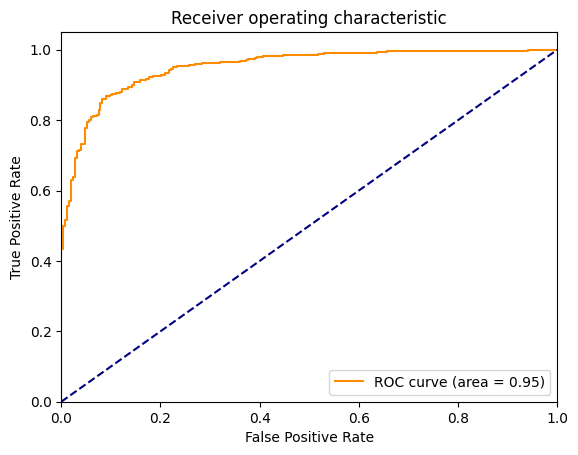

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# Assuming 'predictions' are the predicted classes and 'true_labels' are the actual labels
predictions = svm_resnet.predict(test_features_resnet)  # Example for predictions using ResNet features
true_labels = test_df['class'].astype(int)  # Convert labels to integer if necessary

# Calculate basic metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

# Calculate the AUC-ROC
# First, you need probabilities instead of predicted classes for AUC-ROC
probabilities = svm_resnet.predict_proba(test_features_resnet)[:, 1]  # Probabilities of the positive class
auc_roc = roc_auc_score(true_labels, probabilities)
print("AUC-ROC: {:.2f}".format(auc_roc))

# Plotting ROC Curve
fpr, tpr, _ = roc_curve(true_labels, probabilities)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


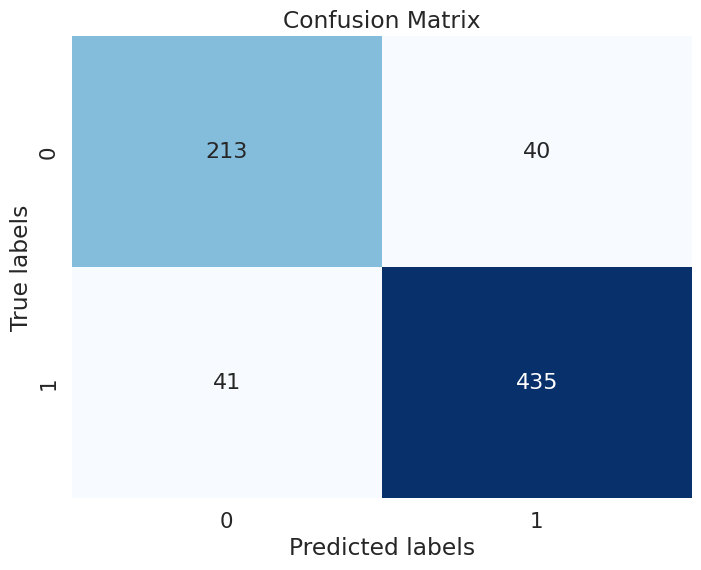

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'predictions' and 'true_labels' are already defined from previous steps
conf_matrix = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)  # fmt='g' avoids scientific notation

# Adding labels and titles
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# True positives, false positives, etc. from the confusion matrix
TP = 435
FP = 40
TN = 213
FN = 41

# Calculating Precision and NPV
precision = precision_score(true_labels, predictions)  # or TP / (TP + FP)
npv = TN / (TN + FN)

# Calculating Likelihood Ratios
plr = (TP / (TP + FN)) / (FP / (TN + FP))
nlr = (FN / (TP + FN)) / (TN / (TN + FP))

print(f"Precision (PPV): {precision:.2f}")
print(f"Negative Predictive Value (NPV): {npv:.2f}")
print(f"Positive Likelihood Ratio (PLR): {plr:.2f}")
print(f"Negative Likelihood Ratio (NLR): {nlr:.2f}")

# These metrics help in understanding the efficacy of the test and guiding clinical decisions.


Precision (PPV): 0.92
Negative Predictive Value (NPV): 0.84
Positive Likelihood Ratio (PLR): 5.78
Negative Likelihood Ratio (NLR): 0.10


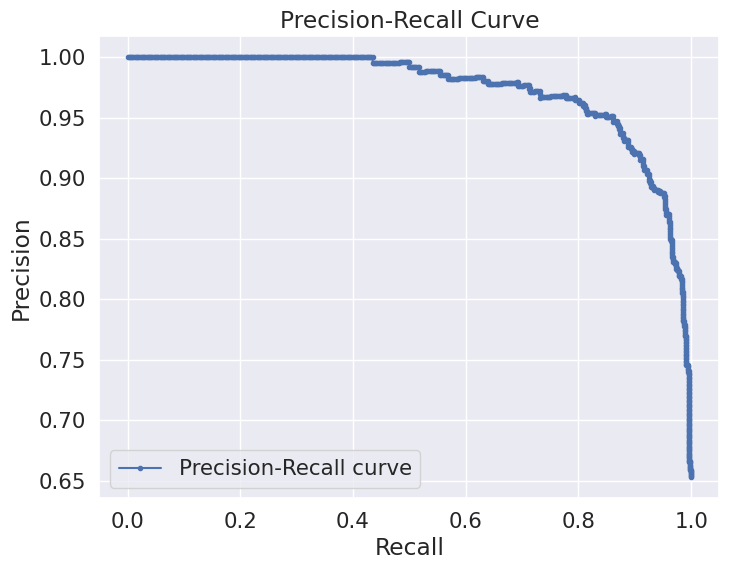

In [30]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(true_labels, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [32]:
pip install scikit-plot


Note: you may need to restart the kernel to use updated packages.


<Figure size 1000x500 with 0 Axes>

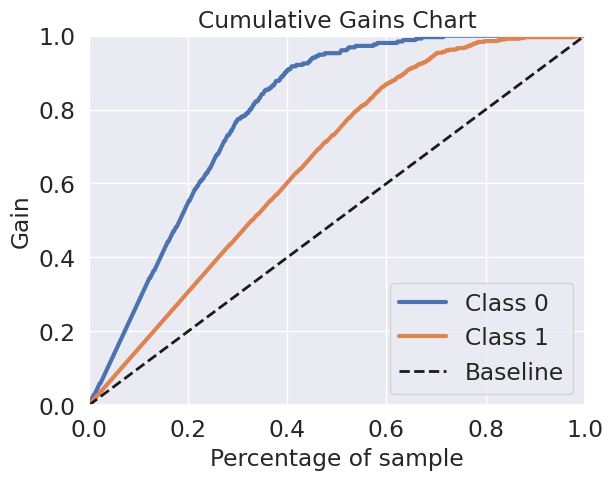

<Figure size 1000x500 with 0 Axes>

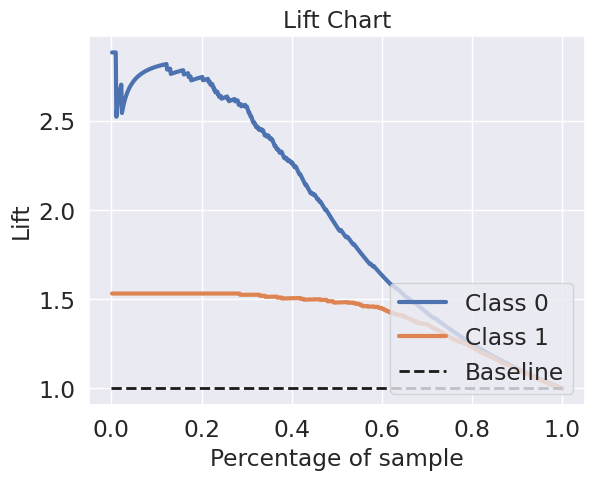

In [33]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# Assuming 'probabilities' contain the predicted probabilities for the positive class
# and 'true_labels' are your actual labels

# Convert probabilities to a format suitable for the scikit-plot functions
y_probas = np.vstack((1-probabilities, probabilities)).T

# Plotting Cumulative Gains Chart
plt.figure(figsize=(10, 5))
skplt.metrics.plot_cumulative_gain(true_labels, y_probas)
plt.title('Cumulative Gains Chart')
plt.show()

# Plotting Lift Chart
plt.figure(figsize=(10, 5))
skplt.metrics.plot_lift_curve(true_labels, y_probas)
plt.title('Lift Chart')
plt.show()


In [34]:
TP = 435  # Adjust these values based on your actual data
FP = 40
TN = 213
FN = 41

# Calculating the metrics
precision = TP / (TP + FP)  # PPV
npv = TN / (TN + FN)
sensitivity = TP / (TP + FN)  # Recall
specificity = TN / (TN + FP)

# Display the results
print(f"Precision (PPV): {precision:.3f}")
print(f"Negative Predictive Value (NPV): {npv:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")


Precision (PPV): 0.916
Negative Predictive Value (NPV): 0.839
Sensitivity (Recall): 0.914
Specificity: 0.842


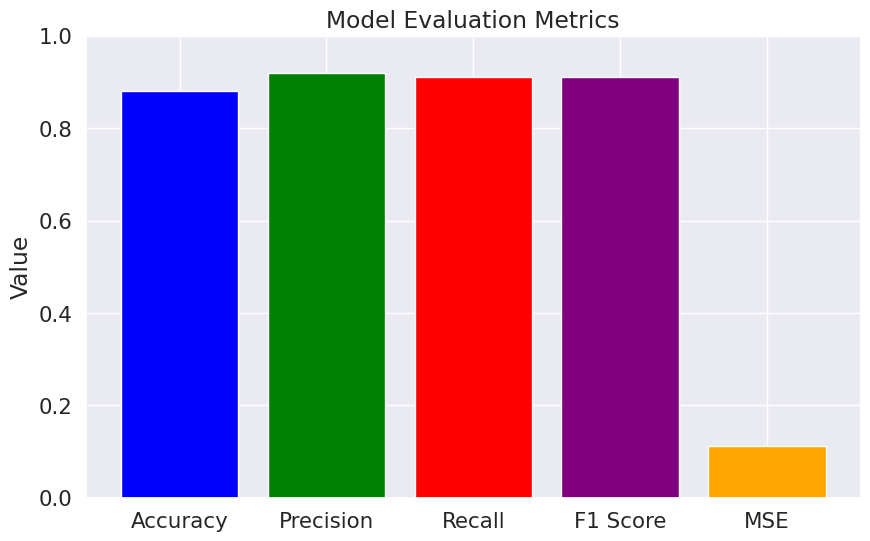

In [40]:
import matplotlib.pyplot as plt

# Example metric values (replace these with your actual metrics)
accuracy = 0.88  # Example accuracy
precision = 0.92  # Example precision
recall = 0.91  # Example recall
f1_score = 0.91  # Example F1 score
mse = 0.11313103976098796  # Your computed MSE

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MSE']
values = [accuracy, precision, recall, f1_score, mse]

# Convert MSE to a comparable scale if needed (e.g., 1 - MSE for visualization purposes)
# values[-1] = 1 - values[-1]  # Uncomment if you want to normalize MSE for comparison

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('Value')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # Ensure y-axis starts at 0 and ends at 1 for probability comparison
plt.show()


In [21]:
image_path = 'testimage.jpeg'

In [22]:
pip install Pillow


Note: you may need to restart the kernel to use updated packages.


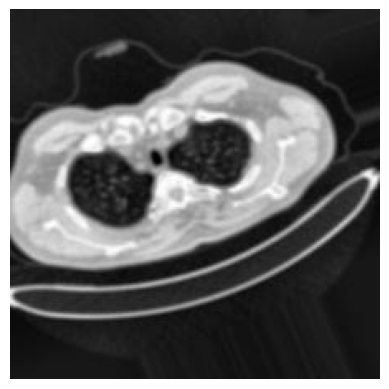

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to your image
image_path = 'testimage.jpeg'  # Make sure the path is correct

# Load the image
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [24]:


def prepare_image(image_path):
    # Load and resize the image
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img)

    # Preprocess the image for each model
    img_vgg = preprocess_vgg(np.expand_dims(img_array, axis=0))
    img_resnet = preprocess_resnet(np.expand_dims(img_array, axis=0))

    # Extract features
    features_vgg = vgg_model.predict(img_vgg).reshape(1, -1)
    features_resnet = resnet_model.predict(img_resnet).reshape(1, -1)

    return features_vgg, features_resnet


In [25]:
def predict_and_average(image_path):
    # Prepare the image and extract features
    features_vgg, features_resnet = prepare_image(image_path)

    # Predict with both SVMs
    prob_vgg = svm_vgg.predict_proba(features_vgg)[0]
    prob_resnet = svm_resnet.predict_proba(features_resnet)[0]

    # Average the probabilities
    average_prob = (prob_vgg + prob_resnet) / 2
    final_prediction = np.argmax(average_prob)

    return final_prediction, average_prob


In [26]:
image_path ='testimage.jpeg'
prediction, probabilities = predict_and_average(image_path)
print("Predicted Class:", prediction)
print("Probability Distribution:", probabilities)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: 1
Probability Distribution: [0.41666127 0.58333873]
